<h1>Biderectional LSTM</h1>


<h3>1. in this step we import al the required python libraries for model building.</h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

<h3>2). load and explore the cleaned dataset.</h3>

In [3]:
file_path = r"C:\D_Drive\DLproject\CreditCardFraudProject\data\CreditCardData_Cleaned.csv"
df = pd.read_csv(file_path)

In [4]:
df.shape

(14997, 39)

In [5]:
df.head()

,Day of Week,Time,Type of Card,Amount,Gender,Age,Fraud,Entry Mode_PIN,Entry Mode_Tap,Type of Transaction_Online,...,Country of Residence_Russia,Country of Residence_USA,Country of Residence_United Kingdom,Bank_Barlcays,Bank_HSBC,Bank_Halifax,Bank_Lloyds,Bank_Metro,Bank_Monzo,Bank_RBS
0,2,19,1,21.0,1,46.1,0,False,False,True,...,False,False,True,False,False,False,True,False,False,False
1,1,0,1,6.0,1,52.0,1,False,False,True,...,False,False,True,False,False,False,False,True,False,False
2,1,9,0,7.0,1,43.9,0,True,False,False,...,False,False,True,False,False,False,False,False,True,False
3,2,20,1,17.0,0,31.5,1,False,False,True,...,False,False,True,False,False,False,False,False,False,False
4,2,11,1,27.0,0,33.8,1,False,False,True,...,False,False,True,True,False,False,False,False,False,False


<h3>3).Spilt the dataset into Features and Target</h3>

we saparete the features x and target variable y (fraud is the target column)

In [6]:
X = df.drop("Fraud", axis=1)
y = df["Fraud"]

<h3>4). Spilt and feature scaling </h3>

we spilt the dataset into training and testing . And scale numaric features 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<h3>5). Reshape dataa</h3>

we reshape data for the BiLSTM model. because LSTM model requires 3d inputs.we reshape our dataset so each row is treated as one time stamp

In [8]:
X_train_3D = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_3D = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print("New shape for LSTM input:", X_train_3D.shape)

New shape for LSTM input: (11997, 1, 38)


<h3>6). Build the BiLSTM Model</h3>

In [12]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional


model_bilstm = Sequential([
    Input(shape=(X_train_3D.shape[1], X_train_3D.shape[2])),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_bilstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 1, 256)         │       171,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 343,681 (1.31 MB)

 Trainable params: 343,681 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

<h3>7). Compile and train the model</h3>

In [13]:
model_bilstm.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model_bilstm.fit(
    X_train_3D, y_train,
    validation_data=(X_test_3D, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9281 - loss: 0.2076 - precision: 0.9131 - recall: 0.9393 - val_accuracy: 0.9477 - val_loss: 0.1335 - val_precision: 0.9372 - val_recall: 0.9548
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9477 - loss: 0.1329 - precision: 0.9280 - recall: 0.9659 - val_accuracy: 0.9527 - val_loss: 0.1197 - val_precision: 0.9326 - val_recall: 0.9715
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9514 - loss: 0.1212 - precision: 0.9271 - recall: 0.9753 - val_accuracy: 0.9533 - val_loss: 0.1151 - val_precision: 0.9403 - val_recall: 0.9639
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9527 - loss: 0.1175 - precision: 0.9307 - recall: 0.9738 - val_accuracy: 0.9543 - val_loss: 0.1084 - val_precision: 0.9340 - val_recall: 0.9736
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9545 - loss: 0.1101 - precision: 0.9311 - recall: 0.9774 - val_accuracy: 0.9537 - val_loss: 0.

<h3>8). Evaluate the model performance</h3>

In [14]:
loss, acc, precision, recall = model_bilstm.evaluate(X_test_3D, y_test)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9573 - loss: 0.1032 - precision: 0.9332 - recall: 0.9812
Accuracy: 0.9573
Precision: 0.9332
Recall: 0.9812
F1 Score: 0.9566


<h3>9). Visualize the Training performance</h3>

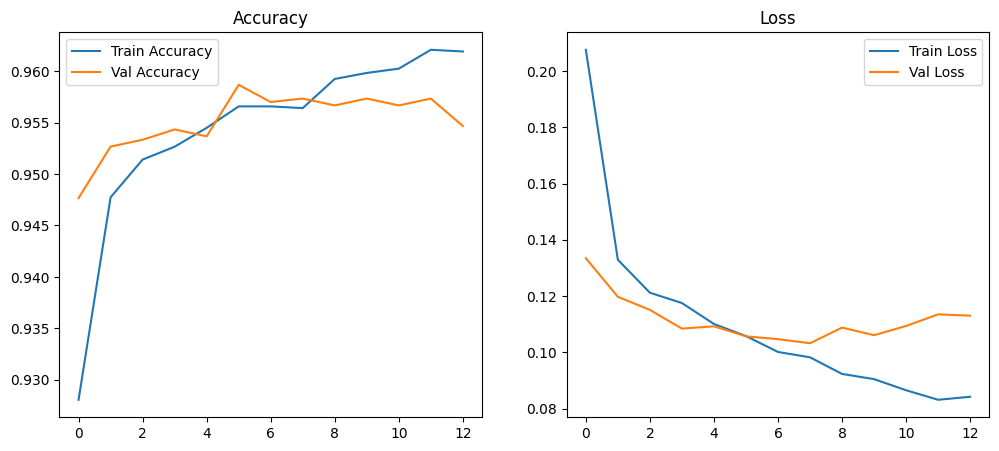

In [15]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()